In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import cv2
import glob
from IPython.display import clear_output
from tqdm import trange

# let matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (19.0, 17.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Data Preprocessing

In [2]:
def load_dataset(flatten=False):
    """
    Load the Dataset from local.
    Then do Preprocessing on it, first set the dimensions of an image and rezise them properly.
    Create diffrent datasets for Training, Validation and Testing.
    
    """
    data_dir = r'./dataset/'
    classes = ['broadleaf', 'grass', 'soil', 'soybean'] 

    num_file = 1100 
    all_files = [] 
    num_data =num_file*len(classes)
    Y = np.zeros(num_data)


    for i, cls in enumerate(classes):
        all_files += [f for f in glob.glob(data_dir+cls+'/*.tif')][:num_file]
        Y[i*num_file:(i+1)*num_file] = i # label all classes with int [0.. len(classes)]


    # Image dimension
    im_width = 200
    im_height = 200 
    im_channel = 3
    dim = im_width * im_height * im_channel

    X = np.ndarray(shape=(num_data, im_width, im_height, im_channel), dtype=np.uint8)

    for idx, file in enumerate(all_files):
        X[idx] = cv2.resize(cv2.imread(file), (im_width, im_height))

    X_train = np.empty(shape=(4000,im_width, im_height, im_channel), dtype=np.uint8)
    X_val = np.empty(shape=(200,im_width, im_height, im_channel), dtype=np.uint8)
    X_test = np.empty(shape=(200,im_width, im_height, im_channel), dtype=np.uint8)

    y_train = np.empty(4000)
    y_val = np.empty(200)
    y_test = np.empty(200) 

    for i, cls in enumerate(classes): 
        X_test[50*i:50*(i+1)] = X[np.where(Y == i)[0][:50]]
        X_val[50*i:50*(i+1)] = X[np.where(Y == i)[0][50:100]]
        X_train[1000*i:1000*(i+1)] = X[np.where(Y == i)[0][100:]]

        y_test[50*i:50*(i+1)] = i
        y_val[50*i:50*(i+1)] = i
        y_train[1000*i:1000*(i+1)] = i

    del Y 
    del X

    # Extract features 
    #Shuffle training index
    train_idxs = np.random.permutation(X_train.shape[0])
    y_train  = y_train[train_idxs].astype(int)
    X_train = X_train[train_idxs]

    X_train = np.reshape(X_train, (X_train.shape[0], -1)).astype('float64')
    X_test = np.reshape(X_test, (X_test.shape[0], -1)).astype('float64')
    X_val = np.reshape(X_val, (X_val.shape[0], -1)).astype('float64')

    print("X_train shape", X_train.shape, "| y_train shape:", y_train.shape)
    print("X_test shape", X_test.shape, "| y_test shape:", y_test.shape)
    print("X_val shape", X_val.shape, "| y_val shape:", y_val.shape)

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train shape (4000, 120000) | y_train shape: (4000,)
X_test shape (200, 120000) | y_test shape: (200,)
X_val shape (200, 120000) | y_val shape: (200,)


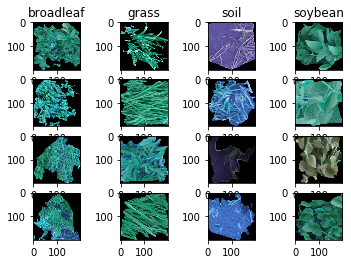

In [3]:
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)
# Visualize some images 
classes = ['broadleaf', 'grass', 'soil', 'soybean']
n_class = len(classes)
samples_per_class = 4
im_width = 200
im_height = 200 
im_channel = 3

for y, cls in enumerate(classes):
    idxes = np.flatnonzero(y == y_train)
    idxes = np.random.choice(idxes, samples_per_class, replace = False)
    for i, idx in enumerate(idxes):
        plt_idx = i * n_class + y + 1
        plt.subplot(samples_per_class,n_class, plt_idx)
        plt.imshow(X_train[idx][:].reshape(im_width, im_height, im_channel).astype('uint8'))
        if(i==0): plt.title(cls)

plt.show()

## Layer

In [4]:
class Layer:
    def __init__(self):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        self.weights = np.zeros(shape=(input.shape[1], 10))
        bias = np.zeros(shape=(10,))
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, 10]
        """
        output = np.matmul(input, self.weights) + bias
        return output

In [5]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.001):
        self.learning_rate = learning_rate
        
        # initialize weights with small random numbers. We use normal initialization
        self.weights = np.random.randn(input_units, output_units)*0.01
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        return np.matmul(input, self.weights) + self.biases
    
    def backward(self,input,grad_output):
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output,np.transpose(self.weights))

        # compute gradient w.r.t. weights and biases
        grad_weights = np.transpose(np.dot(np.transpose(grad_output),input))
        grad_biases = np.sum(grad_output, axis = 0)
        
        # Here we perform a stochastic gradient descent step. 
        # Later on, you can try replacing that with something better.
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        return grad_input

# Activation Function
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        return np.maximum(0,input)
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output*relu_grad 

## Loss Function

In [6]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    return (- ones_for_answers + softmax) / logits.shape[0]

In [7]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X
    for i in range(len(network)):
        activations.append(network[i].forward(X))
        X = network[i].forward(X)
        
    assert len(activations) == len(network)
    return activations

## Predict

In [8]:
def predict(network,X):
    """
    Compute network predictions.
    """
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

## Train

In [9]:
def train(network,X,y):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    Then you can run layer.backward going from last to first layer.
    After you called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    for i in range(1, len(network)):
        loss_grad = network[len(network) - i].backward(layer_activations[len(network) - i - 1], loss_grad)
    
    return np.mean(loss)

## Create Network

In [10]:
output = 4
network = []
network.append(Dense(X_train.shape[1],1000))
network.append(ReLU())
network.append(Dense(1000,500))
network.append(ReLU())
network.append(Dense(500,200))
network.append(ReLU())
network.append(Dense(200,30))
network.append(ReLU())
network.append(Dense(30,output))

In [11]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

Epoch 49
Train accuracy: 0.72225
Val accuracy: 0.72


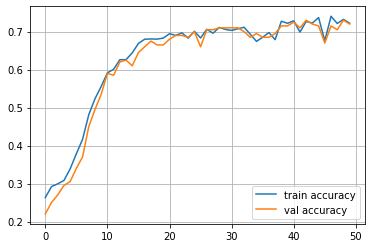

In [12]:
train_log = []
val_log = []
for epoch in range(50):

    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=200,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [13]:
pred = np.mean(predict(network,X_test)==y_test)
print("The Accuracy on the Testset is:"+str(pred))

The Accuracy on the Testset is:0.725
